---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [2]:
import pandas as pd
import numpy as np

# First we read the data to a DataFrame and do some exploratory analysis and data cleaning.
df = pd.read_csv('train.csv',encoding = 'ISO-8859-1')
df.head(2)

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
ticket_id                     250306 non-null int64
agency_name                   250306 non-null object
inspector_name                250306 non-null object
violator_name                 250272 non-null object
violation_street_number       250306 non-null float64
violation_street_name         250306 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    246704 non-null float64
mailing_address_str_name      250302 non-null object
city                          250306 non-null object
state                         250213 non-null object
zip_code                      250305 non-null object
non_us_str_code               3 non-null object
country                       250306 non-null object
ticket_issued_date            250306 non-null object
hearing_date                  237815 non-null object
violation_code                250306 non-null obj

In [4]:
from sklearn.preprocessing import LabelEncoder
# encode choosen column to numerical labels.
le = LabelEncoder()
df['agency_name'] = le.fit_transform(df.agency_name)

# Choosing the columns to work with
data = df[['ticket_id','agency_name','ticket_issued_date','hearing_date','fine_amount','late_fee',
            'judgment_amount','compliance']]

data.dropna(subset=['compliance'], how='all', inplace = True)

# Set 'ticket_id' as a index
data.set_index('ticket_id',inplace=True)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# Set the relevant columns as a dates and add new column
data['hearing_date'] = pd.to_datetime(data['hearing_date'])
data['ticket_issued_date'] = pd.to_datetime(data['ticket_issued_date'])
time = (data['hearing_date'] - data['ticket_issued_date'])
data['num_days_between_report_hearing'] = time.dt.days[time.dt.days >= 0]
data = data[np.isfinite(data['num_days_between_report_hearing'])]

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [6]:
data.shape

(159573, 8)

In [7]:
data.describe()

,agency_name,fine_amount,late_fee,judgment_amount,compliance,num_days_between_report_hearing
count,159573.000000,159573.000000,159573.000000,159573.000000,159573.000000,159573.000000
mean,0.516923,356.856755,33.664742,420.486152,0.071585,72.749387
std,0.756689,675.672888,67.704086,742.605232,0.257800,62.451159
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,200.000000,10.000000,250.000000,0.000000,31.000000
50%,0.000000,250.000000,25.000000,305.000000,0.000000,54.000000
75%,1.000000,250.000000,25.000000,305.000000,0.000000,100.000000
max,4.000000,10000.000000,1000.000000,11030.000000,1.000000,7933.000000


In [8]:
data.compliance.value_counts() #In our case, the data is not balanced. "sad, so sad" - Donald 'J Trump

0.0    148150
1.0     11423
Name: compliance, dtype: int64

/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


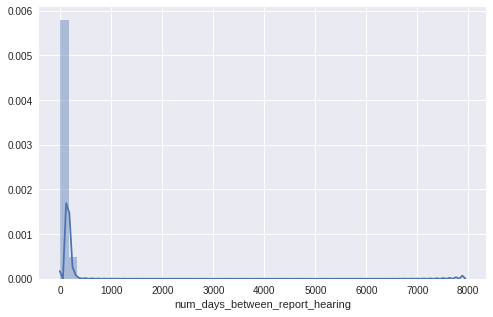

In [9]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = (8, 5)

sns.distplot(data['num_days_between_report_hearing'])

In [10]:
data = data[data.num_days_between_report_hearing < 400]

/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


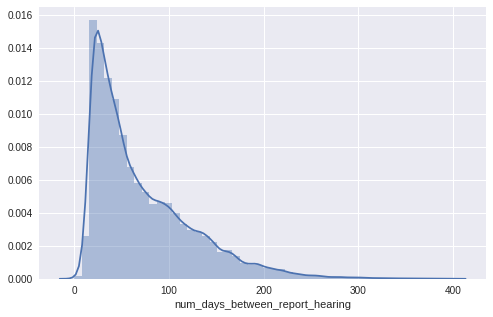

In [11]:
sns.distplot(data['num_days_between_report_hearing'])

In [12]:
data.shape

(159281, 8)

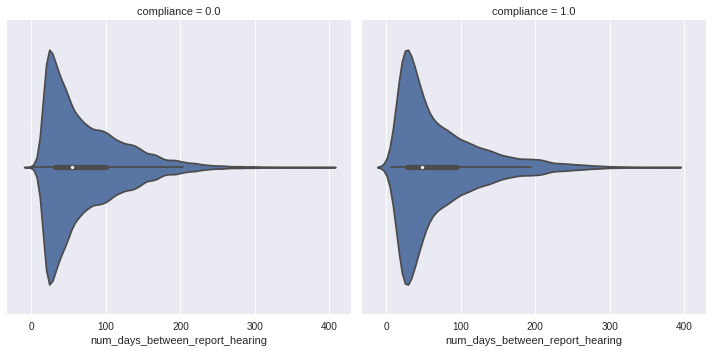

In [13]:
sns.factorplot(x="num_days_between_report_hearing", col="compliance",
               data=data, kind="violin", size=5, aspect= 1);

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Scaling and split the data
X, y = data[['fine_amount','late_fee','judgment_amount']], data['compliance']

scaler = MinMaxScaler()

normData = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)


X_train, X_test, y_train, y_test = train_test_split(normData, y, random_state = 0)

normData.describe()

,fine_amount,late_fee,judgment_amount
count,159281.000000,159281.000000,159281.000000
mean,0.035696,0.033676,0.038132
std,0.067598,0.067739,0.067357
min,0.000000,0.000000,0.000000
25%,0.020000,0.010000,0.022665
50%,0.025000,0.025000,0.027652
75%,0.025000,0.025000,0.027652
max,1.000000,1.000000,1.000000


In [15]:
df_test = pd.read_csv('test.csv',encoding = 'ISO-8859-1')

# Adjusting the real test data
df_test['agency_name'] = le.fit_transform(df_test.agency_name)
data_test = df_test[['ticket_id','agency_name','ticket_issued_date','hearing_date','fine_amount','late_fee',
                     'judgment_amount']]

# Set 'ticket_id' as a index
data_test.set_index('ticket_id',inplace=True)

data_test['hearing_date'] = pd.to_datetime(data_test['hearing_date'])
data_test['ticket_issued_date'] = pd.to_datetime(data_test['ticket_issued_date'])
time = data_test['hearing_date'] - data_test['ticket_issued_date']
data_test['num_days_between_report_hearing'] = time.dt.days[time.dt.days >= 0]
agency_name = data_test.agency_name
data_test = data_test[['fine_amount','late_fee', 'judgment_amount']]


normData_test = pd.DataFrame(scaler.fit_transform(np.nan_to_num(data_test)), index=data_test.index, columns=data_test.columns)

normData_test.describe()

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

,fine_amount,late_fee,judgment_amount
count,61001.000000,61001.000000,61001.000000
mean,0.027271,0.025116,0.022360
std,0.036010,0.036310,0.029569
min,0.000000,0.000000,0.000000
25%,0.005000,0.005000,0.005463
50%,0.020000,0.010000,0.016068
75%,0.025000,0.025000,0.019603
max,1.000000,1.000000,1.000000


In [16]:
# Model chossing and parameters/hyperparameters evaluating
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
parameters = {'C':[0.01, 0.1, 1, 10, 100]}

clf = GridSearchCV(estimator=LogisticRegression(), cv = 10, param_grid = parameters, scoring = 'roc_auc')

clf.fit(X_train, y_train)
print("Best Score: roc_auc", clf.best_score_)
print('Best C:',clf.best_estimator_.C) 

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Best Score: roc_auc 0.7477851452700193
Best C: 1


In [17]:
# LogisticRegression implementation
clf_lr = LogisticRegression(C=100,class_weight='balanced').fit(X_train, y_train)
clf_lr.predict(X_test)
print("roc_auc_score:",roc_auc_score(y_test, clf_lr.predict(X_test)))

roc_auc_score: 0.69170867435


In [18]:
'''
from sklearn.svm import SVC

parameters = {'C':[0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.05, 0.1, 1, 10, 100]}
clf = GridSearchCV(estimator=SVC('rbf'), cv = 6, param_grid = parameters)
print('bdika bdik')
clf.fit(X_train, y_train)

print("Best Score:", clf.best_score_)
print('Best C:',clf.best_estimator_.C) 
print('Best Gamma:',clf.best_estimator_.gamma)
'''

'\nfrom sklearn.svm import SVC\n\nparameters = {\'C\':[0.01, 0.1, 1, 10, 100], \'gamma\':[0.001, 0.01, 0.05, 0.1, 1, 10, 100]}\nclf = GridSearchCV(estimator=SVC(\'rbf\'), cv = 6, param_grid = parameters)\nprint(\'bdika bdik\')\nclf.fit(X_train, y_train)\n\nprint("Best Score:", clf.best_score_)\nprint(\'Best C:\',clf.best_estimator_.C) \nprint(\'Best Gamma:\',clf.best_estimator_.gamma)\n'

In [19]:
'''
svm = SVC(kernel='rbf', C=1).fit(X_train, y_train)
pre_svm = svm.predict(X_test, y_test)
f1_score(y_test, spre_svm)
'''

"\nsvm = SVC(kernel='rbf', C=1).fit(X_train, y_train)\npre_svm = svm.predict(X_test, y_test)\nf1_score(y_test, spre_svm)\n"

In [20]:
# Model chossing and parameters/hyperparameters evaluating
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier(n_jobs=-1, random_state=0)

parameters = {'criterion':['entropy', 'gini'], 'max_features':[1,2,3], 
              'max_depth':[2, 3, 4, 5], 'n_estimators':[30,60]}

clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid = parameters, scoring = 'roc_auc')

clf.fit(X_train, y_train)
print("Best roc_auc_score:", clf.best_score_)
print('Best max_depth:',clf.best_estimator_.max_depth) 
print('Best max_features:',clf.best_estimator_.max_features) 
print('Best criterion:',clf.best_estimator_.criterion) 
print('Best n_estimators:',clf.best_estimator_.n_estimators) 

Best roc_auc_score: 0.7521773185828327
Best max_depth: 5
Best max_features: 3
Best criterion: entropy
Best n_estimators: 60


In [21]:
# RandomForestClassifier implementation
clf_rf = RandomForestClassifier(max_features=3, criterion='entropy', random_state=0, 
                                class_weight='balanced', max_depth=5, n_estimators=30).fit(X_train, y_train)
clf_rf_pred = clf_rf.predict(X_test)
print("roc_auc_score:", roc_auc_score(y_test, clf_rf_pred))

roc_auc_score: 0.700796405913


In [21]:
import pandas as pd
import numpy as np

def blight_model():
    finel = pd.DataFrame(clf_rf.predict_proba(normData_test), index=normData_test.index, columns=['zero','compliance'])
    finel.compliance
    return finel.compliance
blight_model()

ticket_id
284932    0.436911
285362    0.263309
285361    0.364486
285338    0.436911
285346    0.364486
285345    0.436911
285347    0.345651
285342    0.849531
285530    0.263309
284989    0.282671
285344    0.345651
285343    0.263309
285340    0.263309
285341    0.345651
285349    0.364486
285348    0.436911
284991    0.282671
285532    0.282671
285406    0.282671
285001    0.282671
285006    0.263309
285405    0.263309
285337    0.282671
285496    0.345651
285497    0.436911
285378    0.263309
285589    0.282671
285585    0.436911
285501    0.364486
285581    0.263309
            ...   
376367    0.279263
376366    0.358942
376362    0.358942
376363    0.436911
376365    0.279263
376364    0.358942
376228    0.358942
376265    0.358942
376286    0.918723
376320    0.358942
376314    0.358942
376327    0.918723
376385    0.918723
376435    0.904954
376370    0.918723
376434    0.345651
376459    0.364486
376478    0.059736
376473    0.358942
376484    0.394102
376482    0.282671
37